# Configure environment


In [1]:
!nvidia-smi

Wed Nov 18 18:19:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P2000        On   | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P0    N/A /  N/A |    358MiB /  4031MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvidia-settings -q CUDACores -t

768
768


In [3]:
!lscpu

Architektur:                     x86_64
CPU Operationsmodus:             32-bit, 64-bit
Byte-Reihenfolge:                Little Endian
Adressgrößen:                    39 bits physical, 48 bits virtual
CPU(s):                          12
Liste der Online-CPU(s):         0-11
Thread(s) pro Kern:              2
Kern(e) pro Socket:              6
Sockel:                          1
NUMA-Knoten:                     1
Anbieterkennung:                 GenuineIntel
Prozessorfamilie:                6
Modell:                          158
Modellname:                      Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
Stepping:                        10
CPU MHz:                         985.631
Maximale Taktfrequenz der CPU:   4300,0000
Minimale Taktfrequenz der CPU:   800,0000
BogoMIPS:                        5199.98
Virtualisierung:                 VT-x
L1d Cache:                       192 KiB
L1i Cache:                       192 KiB
L2 Cache:                        1,5 MiB
L3 Cache:                   

In [94]:
import os
import numpy as np
import pandas as pd

In [95]:
running_type = 'C'
threads = 6
experiments = 10

types = [
    {'name': 'S', 'max': 1, 'partitions': 1}, 
    {'name': 'O', 'max': 24, 'partitions': 16}, 
    {'name': 'C', 'max': 128 * 4, 'partitions': 20}
]

for t in types:
    for threads in np.linspace(1, t['max'], t['partitions']):
        for e in range(experiments):
            os.system("./bin/violajones {} {}".format(t['name'], int(threads)))

In [96]:
!cat output.csv

S, 18.288577,18.2886,1,-1,128,6
S, 18.156539,18.1565,1,-1,128,6
S, 19.555267,19.5553,1,-1,128,6
S, 19.6866,19.0069,1,-1,128,6
S, 18.351117,18.3511,1,-1,128,6
S, 20.55138,20.0551,1,-1,128,6
S, 20.709276,20.7093,1,-1,128,6
S, 17.265230,17.2652,1,-1,128,6
S, 17.329105,17.3291,1,-1,128,6
S, 17.250755,17.2508,1,-1,128,6
O, 16.926228,16.9262,1,-1,128,6
O, 17.89768,17.0898,1,-1,128,6
O, 20.453741,20.4537,1,-1,128,6
O, 19.853992,19.854,1,-1,128,6
O, 18.230821,18.2308,1,-1,128,6
O, 17.352812,17.3528,1,-1,128,6
O, 17.327422,17.3274,1,-1,128,6
O, 17.287309,17.2873,1,-1,128,6
O, 17.304522,17.3045,1,-1,128,6
O, 17.293077,17.2931,1,-1,128,6
O, 10.999737,10.9997,2,-1,128,6
O, 11.654942,11.6549,2,-1,128,6
O, 12.554110,12.5541,2,-1,128,6
O, 11.275475,11.2755,2,-1,128,6
O, 11.220646,11.2207,2,-1,128,6
O, 12.620328,12.6203,2,-1,128,6
O, 11.476272,11.4763,2,-1,128,6
O, 12.280127,12.2801,2,-1,128,6
O, 12.80149,12.0802,2,-1,128,6
O, 12.538747,12.5388,2,-1,128,6
O, 8.997107,8.99711,4,-1,128,6
O, 9.382748,9.3

In [97]:
import pandas as pd
df = pd.read_csv("output.csv", names=('Type', "Time 1", "Time 2", "Threads", "Blocks", "Cores", "MPs"))
df

,Type,Time 1,Time 2,Threads,Blocks,Cores,MPs
0,S,18.288577,18.288600,1,-1,128,6
1,S,18.156539,18.156500,1,-1,128,6
2,S,19.555267,19.555300,1,-1,128,6
3,S,19.686600,19.006900,1,-1,128,6
4,S,18.351117,18.351100,1,-1,128,6
...,...,...,...,...,...,...,...
735,C,0.953363,0.953367,512,4997,128,6
736,C,0.949048,0.949051,512,4997,128,6
737,C,1.249130,1.024920,512,4997,128,6
738,C,0.982893,0.982897,512,4997,128,6


In [98]:
df["Time"] = df[["Time 1", "Time 2"]].mean(axis = 1)

In [99]:
sequential = (df.iloc[0][1] + df.iloc[0][2]) / 2
df.insert(0, "Speedup", df['Time'].apply(lambda x: float(sequential / float(x)), 0), True)
df["Speedup"] = df["Speedup"].apply(pd.to_numeric)

In [100]:
df.Speedup

0       1.000000
1       1.007274
2       0.935225
3       0.945305
4       0.996593
         ...    
735    19.183197
736    19.270426
737    16.084597
738    18.606859
739    18.978721
Name: Speedup, Length: 740, dtype: float64

In [101]:
df[df.Type == running_type].groupby(["Threads", "Blocks"]).mean().reset_index()

,Threads,Blocks,Speedup,Time 1,Time 2,Cores,MPs,Time
0,1,319801,6.137620,2.979774,2.979776,128,6,2.979775
1,1,1279201,5.837655,3.271301,3.004788,128,6,3.138044
2,27,11845,18.911045,0.967134,0.967137,128,6,0.967136
3,27,47378,18.826423,0.971462,0.971465,128,6,0.971464
4,54,5923,18.697501,0.988186,0.971215,128,6,0.979700
5,54,23689,18.800130,0.972800,0.972803,128,6,0.972802
6,81,3949,18.879323,0.968723,0.968727,128,6,0.968725
7,81,15793,18.770920,0.974321,0.974325,128,6,0.974323
8,108,2962,19.197876,0.952646,0.952649,128,6,0.952647
9,108,11845,18.543015,1.002556,0.974687,128,6,0.988621


<AxesSubplot:xlabel='Threads'>

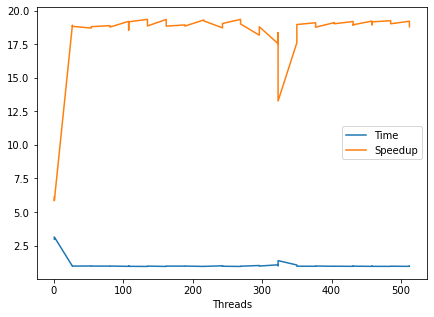

In [102]:
running_type = "C"
df[df.Type == running_type].groupby(["Threads", "Blocks"]).mean().reset_index()[["Threads", "Time", "Speedup"]].plot(x="Threads", y=["Time", "Speedup"], figsize=(7, 5))

In [ ]:
!ls /usr/local/cuda/bin/nvprof*

/usr/local/cuda/bin/bin2c
/usr/local/cuda/bin/computeprof
/usr/local/cuda/bin/cudafe
/usr/local/cuda/bin/cudafe++
/usr/local/cuda/bin/cuda-gdb
/usr/local/cuda/bin/cuda-gdbserver
/usr/local/cuda/bin/cuda-install-samples-8.0.sh
/usr/local/cuda/bin/cuda-memcheck
/usr/local/cuda/bin/cuobjdump
/usr/local/cuda/bin/fatbinary
/usr/local/cuda/bin/g++
/usr/local/cuda/bin/gcc
/usr/local/cuda/bin/gpu-library-advisor
/usr/local/cuda/bin/nsight
/usr/local/cuda/bin/nvcc
/usr/local/cuda/bin/nvcc.profile
/usr/local/cuda/bin/nvdisasm
/usr/local/cuda/bin/nvlink
/usr/local/cuda/bin/nvprof
/usr/local/cuda/bin/nvprune
/usr/local/cuda/bin/nvvp
/usr/local/cuda/bin/ptxas

/usr/local/cuda/bin/crt:
link.stub  prelink.stub


In [ ]:
!./bin/pi

In [ ]:
!tail output2.csv

82,431,0.243425
82,458,0.244504
82,485,0.251062
82,512,0.23940840,120,0.425272
40,120,0.320597
40,120,0.359431
40,120,0.357095
40,120,0.358252
40,120,0.343038
40,120,0.389715


In [ ]:
!nvprof -V

nvprof: NVIDIA (R) Cuda command line profiler
Copyright (c) 2012 - 2016 NVIDIA Corporation
Release version 8.0.61 (21)


In [ ]:
%%shell

/usr/local/cuda-10.0/bin/./nvprof ./bin/pi

==4433== NVPROF is profiling process 4433, command: ./bin/pi
==4433== Profiling application: ./bin/pi
==4433== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  240.74ms         1  240.74ms  240.74ms  240.74ms  calcPi(float*, long, long)
                    0.00%  6.3040us         1  6.3040us  6.3040us  6.3040us  red(float*)
                    0.00%  2.2080us         1  2.2080us  2.2080us  2.2080us  [CUDA memset]
                    0.00%  1.6000us         1  1.6000us  1.6000us  1.6000us  [CUDA memcpy DtoH]
      API calls:   54.81%  240.77ms         1  240.77ms  240.77ms  240.77ms  cudaMemcpy
                   44.96%  197.53ms         1  197.53ms  197.53ms  197.53ms  cudaMalloc
                    0.09%  412.48us         1  412.48us  412.48us  412.48us  cuDeviceTotalMem
                    0.05%  198.37us         1  198.37us  198.37us  198.37us  cudaFree
                    0.03%  148.90us        90  1.6540